In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Problem:

Design an experiment to identify existing users based on their accelerometer data.

## Data:

22 csv files, one for each participant, each containing timestamp, x-, y-, and z-acceleration. In the experiment, the device is held consistently in the front chest pocket of the participant. The *should* mean that the x-, y-, and z-axes are consistent from user to user, however, that may prove to be a stretch. The length of each time series also varies significantly, from as little as 10-20 seconds of usable data, up to several minutes. 

## Experiment Design:

We want to match test data from users with the same users in our database, so we'll split each time series into a training and test section. The first 80% of each time series will be used for training, and the last 20% will be set aside for testing. We're essentially looking for similarities between the test and training sets, so clustering and/or similarity-identifying (Euclidean distance, cosine similarity, etc) models or metrics will likely be used. 

## Approach:

At first glance, two approaches seem feasible. 

First, we could try to build a black-box model that looks at the raw time-series data directly. This could potentially identify complex patterns in the acceleration data that aren't captured by simple metrics. It would also be quite a challenge, and with only 22 participants, could easily overfit the data, or use an artifact from data collection to base its predictions on. 

Second, we could engineer more general features by hand that make intuitive sense (average acceleration amplitude, period/cadence of gait), and then apply a simple similarity metric to weigh each test case against each of the participants. 

Better to start simple to get some kind of reasonable result before moving to a complicated model, so I'll start with the second approach of feature engineering and a simple metric.

## Evaluation:

How will we know if the model is working? First, given a random test participant, we can calculate the similarity score for every training example, and see which training participant is the most similar to the test participant. If the correct participant is near the top of the list each time, we're at least on the right track.

Beyond that, we could define a custom metric to look at how much better the "right" solution is that the median, and perhaps turn that into a probability prediction for with participant is our best guess to match the training data. For this short exercise, I'll start by comparing the raw metric results and using rank to see how well we did.

## Data Exploration on One Participant
Let's start by exploring the data and producing the metrics for a single participant.

In [2]:
n_participant = 1
df_raw = pd.read_csv("Data/" + str(n_participant) + ".csv", header=None, names=['t', 'x_acc', 'y_acc', 'z_acc'])

In [3]:
df_raw.head()

,t,x_acc,y_acc,z_acc
0,0.000000,0.69464,3.17350,7.5048
1,0.030639,0.14982,3.48680,9.2755
2,0.069763,-0.29965,1.94770,9.1120
3,0.099823,-1.68890,1.41650,10.1200
4,0.129820,-2.17930,0.95342,10.9240


In [4]:
df_raw.describe()

,t,x_acc,y_acc,z_acc
count,5069.00000,5069.000000,5069.000000,5069.000000
mean,76.81745,-3.554254,8.557989,-0.844095
std,44.23811,2.486629,2.956517,2.913708
min,0.00000,-9.343600,0.000000,-7.927000
25%,38.57000,-5.284700,6.129200,-2.601500
50%,76.82000,-3.486800,8.921300,-1.144100
75%,115.01000,-2.179300,10.651000,-0.040861
max,154.20000,10.951000,15.786000,12.599000


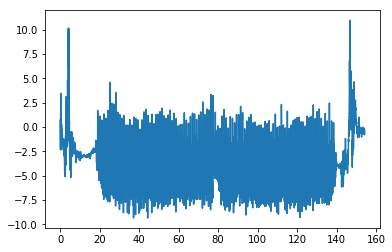

In [5]:
plt.plot(df_raw.t, df_raw.x_acc)
plt.show()

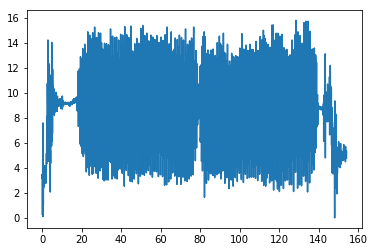

In [6]:
plt.plot(df_raw.t, df_raw.y_acc)
plt.show()

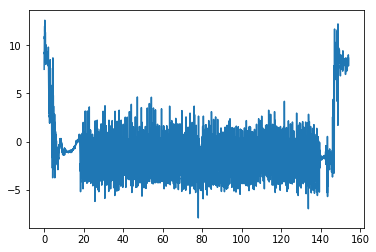

In [7]:
plt.plot(df_raw.t, df_raw.z_acc)
plt.show()

It looks like there is significant noise at the beginning and end of the experiment. We'll have to trim each time-series before we begin our analysis. For this example, we'll be using 25 < t < 135. If we were to productionalize this model to thousands of participants, we could write code to do this automatically, but for 22 cases I'll just do it by hand.

NB: There are several participants with significantly shorter time series. It shouldn't be too much of an issue for our approach, but definitely something we'd need to consider if we were building a more sensitive solution or attempting pattern recognition.

In [8]:
# I've gone ahead and built a cropping dictionary by hand for later...
cropping_dict = {1: (25, 135),
                 2: (60, 125),
                 3: (8, 25),
                 4: (10, 160),
                 5: (4, 17),
                 6: (10, 140),
                 7: (10, 100),
                 8: (15, 85),
                 9: (10, 180),
                 10: (5, 90),
                 11: (15, 160),
                 12: (5, 90),
                 13: (20, 115),
                 14: (10, 115),
                 15: (25, 100),
                 16: (18, 46),
                 17: (100, 280),
                 18: (200, 300),
                 19: (3, 18),
                 20: (50, 250),
                 21: (5, 50),
                 22: (10, 120)}

df_trim = df_raw[(df_raw.t > cropping_dict[n_participant][0]) & (df_raw.t < cropping_dict[n_participant][1])]

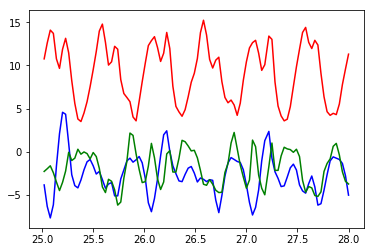

In [9]:
# Zooming into the beginning of the series:
plt.plot(df_trim.t[:100], df_trim.x_acc[:100], c='b')
plt.plot(df_trim.t[:100], df_trim.y_acc[:100], c='r')
plt.plot(df_trim.t[:100], df_trim.z_acc[:100], c='g')
plt.show()

Looking at the acceleration curves in detail, it is clear that there is a consistent, complex pattern of motion. This might be something our black-box method would be good at capturing, however, we'll keep that on hold for now. Also, now that we know we have a reasonably clean data set, we'll remove the test set to avoid contamination.

In [10]:
train_size = int(0.8 * df_trim.shape[0])
df_train = df_trim[:train_size]
df_test = df_trim[train_size:]

We're told in the description of the data that these participants are walking. Assuming they are walking at a fairly consistent pace, their average acceleration in any given direction should be zero over the course of the experiment. Let's center the data around zero to reflect that.

In [11]:
df_temp = df_train.loc[:, ['x_acc', 'y_acc', 'z_acc']].apply(lambda x: x-x.mean()).rename(columns={'x_acc':'x_cent', 'y_acc':'y_cent', 'z_acc':'z_cent'})

df_train = df_train.join(df_temp)

## Feature Engineering

Potentially useful features that we could extract from the time-series:
- average total acceleration
- average time between observations (NB: this may be a result of the device rather than the user, so may need to be excluded)
- period of gait in each direction
- average peak acceleration in each direction (i.e., average max amplitude)
- some measure of the smoothness of gait, perhaps how many times acceleration changes sign per second.

### Average Acceleration and Time Delta

In [12]:
# Total Acceleration Magnitude over time:
df_train['acc'] = np.sqrt(df_train.x_cent ** 2 + df_train.y_cent ** 2 + df_train.z_cent ** 2)

In [13]:
# Metrics:
average_acc = np.mean(df_train['acc'])
average_delta_t = np.mean(df_train.t.diff())

print('Average Acceleration:', average_acc)
print('Average Time Step:', average_delta_t)

Average Acceleration: 3.9167354821497358
Average Time Step: 0.030147462277091912


### Amplitude

In [14]:
# Max and min amplitudes. We'll use 90th/10th percentile values to avoid outliers.
quant_90 = df_train.quantile(.9)
quant_10 = df_train.quantile(.1)


'''
# I don't think we'll actually want to use these, as x-, y-, z-directions may not be consistent across users
x_acc_min = quant_10.x_acc
x_acc_max = quant_90.x_acc
y_acc_min = quant_10.y_acc
y_acc_max = quant_90.y_acc
z_acc_min = quant_10.z_acc
z_acc_max = quant_90.z_acc
'''

acc_min = quant_10.acc
acc_max = quant_90.acc

### Period/Frequency
This ended up being too noisy, so I didn't include it.

In [15]:
# Quick period find using a Fourier transform
# This could get pretty deep into signal processing, so I'll just make sure
# I have a reasonable output and leave it at that for now
padding = 50 # for issues around the origin...

ft = np.fft.rfft(df_train.acc, axis=0)
freqs = np.fft.rfftfreq(df_train.acc.shape[0], df_train.t.iloc[1]-df_train.t.iloc[0])

ft = np.delete(ft, range(padding))
freqs = np.delete(freqs, range(padding))

mags = abs(ft)
signal_freq = freqs[mags.argmax()]

signal_freq

5.850759913152561

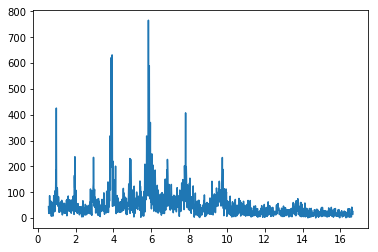

In [16]:
plt.plot(freqs, mags)
plt.show()

### Smoothness (Roughness)

Let's just count up how many times the acceleration magnitude changes directions per second. We could do more research into a more generic measure, but this should work well enough for our purposes, and be consistent across our data set.

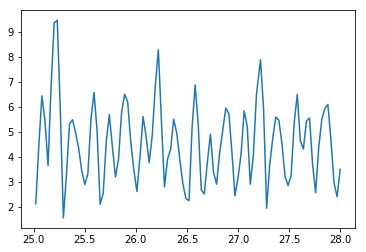

In [17]:
plt.plot(df_train.t[:100], df_train.acc[:100])
plt.show()

In [18]:
# We want to count how many times the acceleration changes direction, so:
delta_acc = df_train.acc.diff()
# Whether acceleration is rising or falling:
sign_acc = np.sign(delta_acc)
# Where that sign changes:
inflection = sign_acc.diff()

total_inflection = sum(abs(inflection.dropna()))/2

total_time = df_train.t.iloc[-1] - df_train.t.iloc[0]

# A higher number means more bumps, so let's call it 'roughness'
roughness = total_inflection/total_time
roughness

13.240814469343645

### Combine Metrics

That should be enough to get us started! Let's build a dataframe with all the participants, and we can also go back later to add more features.

In [19]:
d = {'average_acc': average_acc,
     'average_delta_t': average_delta_t,
     'acc_min': acc_min,
     'acc_max': acc_max,
     'roughness': roughness}

df_metrics = pd.DataFrame(columns=['average_acc', 'average_delta_t', 'acc_min', 'acc_max', 'roughness'])
df_metrics.loc[n_participant] = d

In [20]:
df_metrics

,average_acc,average_delta_t,acc_min,acc_max,roughness
1,3.916735,0.030147,1.907476,5.780055,13.240814


## Iterate over all data files

In [21]:
def create_metrics(df):
    # Let's put it in a function since we want to do the identical processing for train and test sets

    df_temp = df.loc[:, ['x_acc', 'y_acc', 'z_acc']].apply(lambda x: x-x.mean()).rename(columns={'x_acc':'x_cent', 'y_acc':'y_cent', 'z_acc':'z_cent'})
    df = df.join(df_temp)
    
    df['acc'] = np.sqrt(df.x_cent ** 2 + df.y_cent ** 2 + df.z_cent ** 2)
    
    average_acc = np.mean(df['acc'])
    average_delta_t = np.mean(df.t.diff())

    quant_90 = df.quantile(.9)
    quant_10 = df.quantile(.1)

    acc_min = quant_10.acc
    acc_max = quant_90.acc
    
    #freq = dominant_freq(df)
    roughness = find_roughness(df)

    # Formatting for output
    d = {'average_acc': average_acc,
         'average_delta_t': average_delta_t,
         'acc_min': acc_min,
         'acc_max': acc_max,
         'roughness': roughness}
    
    return d

In [22]:
def dominant_freq(df):
    padding = 25 # for issues around the origin...

    ft = np.fft.rfft(df.acc, axis=0)
    freqs = np.fft.rfftfreq(df.acc.shape[0], df.t.iloc[1]-df.t.iloc[0])

    ft = np.delete(ft, range(padding))
    freqs = np.delete(freqs, range(padding))

    mags = abs(ft)
    signal_freq = freqs[mags.argmax()]
    
    return signal_freq

In [23]:
def find_roughness(df):
    inflection = np.sign(df.acc.diff()).diff()
    total_inflection = sum(abs(inflection.dropna()))/2

    total_time = df.t.iloc[-1] - df.t.iloc[0]

    roughness = total_inflection/total_time
    return roughness

In [24]:
cols = ['average_acc', 'average_delta_t', 'acc_min', 'acc_max', 'roughness']
df_metrics_train = pd.DataFrame(columns=cols)
df_metrics_test = pd.DataFrame(columns=cols)


for i in range(1, 23):
    # Loading in data
    n_participant = i
    df_raw = pd.read_csv("Data/" + str(n_participant) + ".csv", header=None, names=['t', 'x_acc', 'y_acc', 'z_acc'])

    # Shaping dataframe
    df_trim = df_raw[(df_raw.t > cropping_dict[n_participant][0]) & (df_raw.t < cropping_dict[n_participant][1])]

    train_size = int(0.8 * df_trim.shape[0])
    df_train = df_trim[:train_size]
    df_test = df_trim[train_size:]

    # Running metrics on train and test sets
    d_train = create_metrics(df_train)
    d_test = create_metrics(df_test)

    df_metrics_train.loc[n_participant] = d_train
    df_metrics_test.loc[n_participant] = d_test

In [25]:
df_metrics_train.head()

,average_acc,average_delta_t,acc_min,acc_max,roughness
1,3.916735,0.030147,1.907476,5.780055,13.240814
2,2.874288,0.031797,1.425900,4.624109,12.082597
3,3.163070,0.030621,1.506851,5.510093,10.910705
4,3.797177,0.030913,0.968969,6.468231,13.873316
5,9.407495,0.031235,5.311086,14.984453,11.764819


In [26]:
df_metrics_test.head()

,average_acc,average_delta_t,acc_min,acc_max,roughness
1,4.136701,0.030206,1.963172,6.136358,13.487738
2,2.012528,0.033235,1.011961,3.212294,12.035661
3,3.114472,0.033148,1.386137,5.162460,10.055866
4,2.979988,0.031491,0.417213,5.619280,14.595661
5,8.550391,0.031145,4.620824,13.653342,8.123791


## Normalization

In order to treat each column with the same weight, we should normalize the training set by column, and then apply those same weights to the test set.

In [27]:
# We'll just do Z-Normalization
mean_vals = df_metrics_train.mean()
std_vals = df_metrics_train.std()

df_train_norm = (df_metrics_train - mean_vals) / std_vals
df_test_norm = (df_metrics_test - mean_vals) / std_vals

df_train_norm.head()

,average_acc,average_delta_t,acc_min,acc_max,roughness
1,0.271869,-1.447062,0.389001,0.050766,0.004660
2,-0.428091,1.302857,-0.123596,-0.447424,-0.865435
3,-0.234186,-0.656819,-0.037431,-0.065582,-1.745802
4,0.191590,-0.170535,-0.609961,0.347355,0.479818
5,3.958681,0.365585,4.011857,4.017672,-1.104161


## Similarity Model

We'll start with a Euclidean Distance and Cosine Similarity to get a score for each training set participant, given a random test set participant.

In [28]:
import sklearn.metrics.pairwise as skl_pairs
import random

In [29]:
cos_sim = skl_pairs.cosine_similarity
euc_dis = skl_pairs.euclidean_distances

In [30]:
n = random.randint(1,22)
#n = 14

X = df_test_norm.loc[n].values.reshape(1, -1)
Y = df_train_norm

euc = euc_dis(X, Y)
cos = cos_sim(X, Y)

df_sim = pd.DataFrame(index=range(1,23))
df_sim['euc'] = euc[0]
df_sim['cos'] = cos[0]
# Estimate strength is roughly "How much better than the median of Euc distance"
df_sim['estimate_strength'] = df_sim.apply(lambda x: 1 - (x/x.median()))['euc']

In [31]:
print("Actual participant:", n)
df_sim.sort_values(by='estimate_strength', ascending=False)

Actual participant: 5


,euc,cos,estimate_strength
5,2.950322,0.911274,0.595779
19,6.265800,0.658162,0.141528
13,6.340918,0.492514,0.131236
16,6.432875,0.427990,0.118637
3,6.444595,0.412283,0.117031
18,6.484772,0.559999,0.111527
1,6.861224,0.191562,0.059949
7,6.910289,0.191462,0.053227
15,7.127238,0.044368,0.023503
2,7.159675,0.017747,0.019059


In [32]:
rank = df_sim['estimate_strength'].rank(ascending=False)[n]
score = df_sim['estimate_strength'][n]
print("Rank:", rank, "\nScore:", score)

Rank: 1.0 
Score: 0.5957787233433641


## Evaluate Model for all Test Cases

Now we'll just loop over all the test cases to see how the model did in general.

In [33]:
df_final = pd.DataFrame(columns=['Euclidean Rank', 'Euclidean Distance', 'Cosine Rank', 'Cosine Similarity'])

for i in range(1, 23):
    
    X = df_test_norm.loc[i].values.reshape(1, -1)
    Y = df_train_norm

    euc = euc_dis(X, Y)
    cos = cos_sim(X, Y)

    df_sim = pd.DataFrame(index=range(1,23))
    df_sim['euc'] = euc[0]
    df_sim['cos'] = cos[0]
    df_sim['estimate_strength'] = df_sim.apply(lambda x: 1 - (x/x.median()))['euc']
    
    euc_rank = df_sim['euc'].rank(ascending=True)[i]
    cos_rank = df_sim['cos'].rank(ascending=False)[i]
    euc_score = df_sim['euc'][i]
    cos_score = df_sim['cos'][i]
    
    df_final.loc[i] = [euc_rank, euc_score, cos_rank, cos_score]

In [34]:
# Let's see how we did!
# NB: I decided to keep raw Euc Distance, rather than the "estimate strength" metric.
df_final

,Euclidean Rank,Euclidean Distance,Cosine Rank,Cosine Similarity
1,1.0,0.304577,1.0,0.979875
2,1.0,2.578183,1.0,0.946598
3,10.0,4.266155,10.0,0.236833
4,4.0,1.414832,5.0,0.632869
5,1.0,2.950322,1.0,0.911274
6,3.0,0.723104,3.0,0.895344
7,6.0,1.317331,7.0,0.511981
8,3.0,0.982291,10.0,0.134099
9,2.0,0.879966,2.0,0.945643
10,2.0,0.551372,2.0,0.894278


## Conclusion

I ended up spending more time on feature engineering than on model building, but we've gotten to a decent 4-hour (or 6-hour) solution. We ended up with two similarity metrics, each predicting more than half of the test cases within our top 2 guesses. Cosine Similarity gave a result the same or better than Euclidean Distance in all but 3 cases. It would be interesting to look back and see what kind of samples led to those differences, as well as the cases where both metrics did poorly.  

We could consider using a more complicated model, but with this particular data set, I would be hesitant to do so. By the end this process, we're working with 5 features and 22 rows of data (some of which are based on as few as 15 seconds of recording). Given how few data points we have, I actually think sticking with cosine similarity as a measure of similarity is the right choice. We could use this data set to test out ideas for a pattern-recognizing ML model, but we would ultimately need more data to get it running. Before moving to a more complicated model, I would first try to improve the feature engineering to create more, and more useful, features.

Thanks for reading!